In [1]:
# script for analyzing social interaction assay data

# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.graphics.gofplots import qqplot


In [2]:
# load data

# all male animals
# animals were first tested in a tail flick for two days in a row (days -2 and -1)
# then starting day 0 treated with Drug A or Drug C plus Drug B or drug D days 0 - 4. 
# On days 5 and 6, animals recieved drugs in the morning

# finally, on day 8, animals start social interaction test
# the test involves placing the test animal in a two-sidered chamber and allowing the animal to explore for 10
# minutes. Then a new animal is placed in a cage at one side of the chamber. Times spent interacting on the 
# 'social' side vs on the 'empty' side are recorded and compared

# 'Hours' column refers to time since last drug A or C dose
# 'Distance' column refers to distance traveled during trial in cm, 'Velocity' is cm/sec
# 'EmptySocial' is the number of transfers from the empty side of the chamber to the social side
# 'SocialEmpty' is the number of transfers from the social side to the empty side

# Note that this data is for ONLY the social interaction test

behavior = pd.read_csv('soc_csv_blog.csv')
behavior.head()


,Hours,Wave,Arena,Trial,Animal,Drugs,Distance,Velocity,Mobile,Immobile,...,EmptyDuration,EmptyLatency,SocialFreq,SocialDuration,SocialLatency,EmptySocial,SocialEmpty,TotalTime,EmptyPercent,SocialPercent
0,24,1,Arena 2,Control,1808,A + B,3565.55,6.25810,280.05,297.15,...,250.5,0.00,47,327.65,2.9,26,25,578.15,43.327856,56.672144
1,24,1,Arena 3,Control,1809,A + B,2972.39,5.61145,260.60,276.80,...,278.9,2.45,44,260.70,0.0,29,29,539.60,51.686434,48.313566
2,24,1,Arena 4,Control,1810,A + B,3762.25,6.81999,317.90,245.55,...,232.6,2.10,67,332.45,0.0,30,31,565.05,41.164499,58.835501
3,24,1,Arena 2,Social,1808,A + B,2519.56,4.40984,259.80,316.60,...,145.6,1.00,38,432.10,0.0,20,21,577.70,25.203393,74.796607
4,24,1,Arena 3,Social,1809,A + B,2092.65,3.67615,200.95,372.60,...,165.1,55.50,32,409.35,0.0,18,19,574.45,28.740534,71.259466


In [3]:
# make a percent immobile column
behavior['PercentImmobile'] = 100 * behavior['Immobile']/(behavior['Immobile'] + behavior['Mobile'])


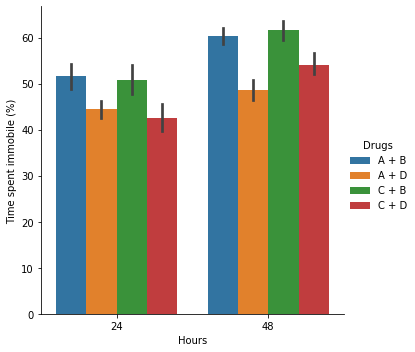

In [4]:
# plot immobile time during social interaction
# setting ci = 68 shows error bars as +/- 1 SEM

fig = sns.catplot(x = 'Hours', y='PercentImmobile', hue = 'Drugs', kind="bar", ci = 68, data = behavior)

plt.ylabel('Time spent immobile (%)')
plt.show()

# uncomment the next line if you want to save the figure
# in your current working directory
# fig.savefig('Fig1.png', dpi = 200)

In [5]:
# Tukey's HSD (Tukey's honest significance test) for determining which groups are significantly different
# note that the second argument for the group identifying factor only takes one value so if you have
# multiple treatment factors in separate columns, combine them to run the tukeyHSD on the resulting
# mc_object

# first we need to combine the Drugs and Hours columns to get a total treatments column
behavior['DrugsTime'] = behavior['Drugs'].map(str) + " + " + behavior['Hours'].map(str)

# now make the comparison object
comparison = MultiComparison(behavior['PercentImmobile'], behavior['DrugsTime'])

# convert the results to a data frame
results = pd.read_html(comparison.tukeyhsd().summary().as_html())[0]

# note that if you run the Tukey HSD separately on each 'Hours' condition, you get different results

# results for TukeyHSD on 24 hour conditions alone
comparison24 = MultiComparison(behavior[behavior['Hours'] == 24]['PercentImmobile'], \
                               behavior[behavior['Hours'] == 24]['Drugs'])

results24 = pd.read_html(comparison24.tukeyhsd().summary().as_html())[0]

# results for TukeyHSD on 48 hour conditions alone
comparison48 = MultiComparison(behavior[behavior['Hours'] == 48]['PercentImmobile'], \
                               behavior[behavior['Hours'] == 48]['Drugs'])

results48 = pd.read_html(comparison48.tukeyhsd().summary().as_html())[0]

# print all the results where the p-value < 0.05
results[results['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
7,A + B + 48,A + D + 24,-15.9792,0.0031,-28.2490,-3.7095,True
11,A + B + 48,C + D + 24,-17.7597,0.0010,-29.3390,-6.1804,True
15,A + D + 24,C + B + 48,17.1506,0.0022,4.3186,29.9825,True
19,A + D + 48,C + B + 48,12.9787,0.0456,0.1467,25.8106,True
25,C + B + 48,C + D + 24,-18.9310,0.0010,-31.1045,-6.7575,True
27,C + D + 24,C + D + 48,11.4998,0.0127,1.5602,21.4394,True


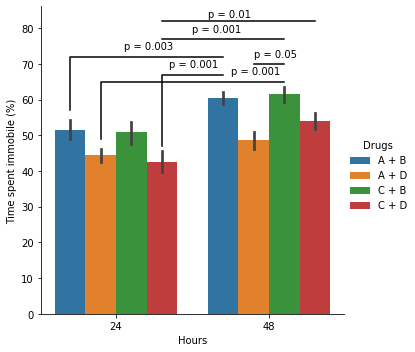

In [6]:
# plot immobile time during social interaction with significance comparisons

fig2 = sns.catplot(x = 'Hours', y='PercentImmobile', hue = 'Drugs', kind="bar", ci = 68, data = behavior)

plt.plot([-0.3, -0.3, 0.7, 0.7], [57, 72, 72, 72], 'k')
plt.text(0.05, 74, 'p = 0.003')
plt.plot([0.3, 0.3, 0.7, 0.7], [47, 67, 67, 67], 'k')
plt.text(0.35, 69, 'p = 0.001')
plt.plot([-0.1, -0.1, 1.1, 1.1], [49, 65, 65, 65], 'k')
plt.text(0.75, 67, 'p = 0.001')
plt.plot([0.9, 0.9, 1.1, 1.1], [70, 70, 70, 70], 'k')
plt.text(0.9, 72, 'p = 0.05')
plt.plot([0.3, 0.3, 1.1, 1.1], [77, 77, 77, 77], 'k')
plt.text(0.5, 79, 'p = 0.001')
plt.plot([0.3, 0.3, 1.3, 1.3], [82, 82, 82, 82], 'k')
plt.text(0.6, 83, 'p = 0.01')

plt.ylabel('Time spent immobile (%)')
plt.show()

# uncomment the next line if you want to save the figure
# in your current working directory
# fig2.savefig('Fig2.png', dpi = 200)

In [7]:
# two way ANOVA for the immobility percent between drug
# treatment groups

# we first make sure to drop any missing values (which show
# up as 'NaN' in the data frame)
behav2 = behavior.dropna()

# multiply by 100 to get a percentage from a fraction
behav2['PercentImmobile'] * 100

# add Drug1 and Drug2 conditons as separate columns
splits = behav2['Drugs'].str.split( '+', expand = True)
behav2['Drug1'] = splits[0]
behav2['Drug2'] = splits[1]

# now define a formula for statsmodels to fit 
formula = 'PercentImmobile ~ Drug1 + Drug2 + Drug1:Drug2'

# we then run the model by calling formula using the data
# in behav2 with the ordinary least squares method in
# statsmodels (the ols function)
model = ols(formula, behav2, missing = 'drop').fit()

# then we create a table of the model results after
# fitting the model
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
Drug1,25.459718,1.0,0.319796,0.573708
Drug2,1187.315194,1.0,14.913696,0.000265
Drug1:Drug2,11.282197,1.0,0.141714,0.707828
Residual,5095.193982,64.0,NaN,NaN


In [66]:
# define a function to determine the eta squared value
# eta squared gives the the proportion of variance associated with one or more 
# main effects, errors or interactions
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

# define a function to determine the omega squared value
# omega squared is a measure of effect size, or the degree of association for a population
# omega^2 estimates how much variance in the response variables are accounted for by the explanatory variables
# this is a lesser biased alternative to eta-squared, especially when sample sizes are small
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

eta_squared(aov_table)
omega_squared(aov_table)

# the eta_squared and omega_squared values get attached to our aov_table
print(aov_table.round(4))

                sum_sq    df        F  PR(>F)  eta_sq  omega_sq
Drug1          25.4597   1.0   0.3198  0.5737  0.0040   -0.0085
Drug2        1187.3152   1.0  14.9137  0.0003  0.1879    0.1731
Drug1:Drug2    11.2822   1.0   0.1417  0.7078  0.0018   -0.0107
Residual     5095.1940  64.0      NaN     NaN     NaN       NaN


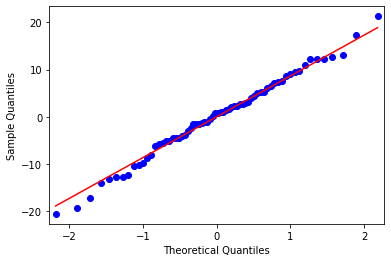

In [70]:
# calculate and plot the residuals of the model

res = model.resid 
fig3 = qqplot(res, line = 's')
plt.show()

# this suggests that there is very little deviation from a linear model and that the data generally
# follow a normal distribution